# Fitting remaining ion current conductances

Using full AP/CaT measures to fit the remaining conductances.

# Imports

In [2]:
# PyABC imports
from pyabc import (ABCSMC, Distribution, RV,
                   History, MedianEpsilon)
from pyabc.populationstrategy import AdaptivePopulationSize
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler

In [3]:
# Custom imports
from ionchannelABC import (ion_channel_sum_stats_calculator,
                           IonChannelAcceptor,
                           IonChannelDistance,
                           EfficientMultivariateNormalTransition,
                           plot_parameter_sensitivity,
                           plot_parameters_kde,
                           plot_distance_weights)

INFO:myokit:Loading Myokit version 1.27.4


In [4]:
# Other necessary imports
import numpy as np
import subprocess
import pandas as pd
import io
import os
import tempfile

In [5]:
# Plotting imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config Inline.Backend.figure_format = 'retina'

# Generate samples of ABC channel results

In [5]:
history = {'icat': History('sqlite:///results/icat/hl-1_icat.db'),
           'ical': History('sqlite:///results/ical/hl-1_ical.db'),
           'ina': History('sqlite:///results/ina/hl-1_ina.db'),
           'ikr': History('sqlite:///results/ikr/hl-1_ikr.db'),
           'ikur': History('sqlite:///results/ikur/hl-1_ikur.db'),
           'ito': History('sqlite:///results/ito/hl-1_ito.db'),
           'iha': History('sqlite:///results/iha/hl-1_iha.db'),
           'ik1': History('sqlite:///results/ik1/hl-1_ik1.db')}

In [6]:
# Set to correct result (last ABC run in database).
for _,h in history.items():
    h.id = len(h.all_runs())

In [7]:
# Generate a sample from all history items.
def generate_sample(history, n):
    samples = [dict() for i in range(n)]
    for k, h in history.items():
        dist = h.get_distribution(m=0)
        weights = dist[1]
        ch_samples = dist[0] \
                    .sample(n, weights=weights, replace=True) \
                    .to_dict(orient='records')
        ch_samples = [{k+'.'+key: value for key, value in ch.items()}
                      for ch in ch_samples]
        for c, s in zip(ch_samples, samples):
            s.update(c)
    return samples

In [8]:
# Generate samples
n_samples = 10000
param_samples = generate_sample(history, n_samples)

# Create full cell model for ABC

In [9]:
from channels.hl1 import hl1 as model

In [10]:
model.add_external_par_samples(param_samples)

In [11]:
model.sample({})

,x,y,exp
0,vrp,-73.168716,0
1,ca_i,0.366109,0
2,k_i,120464.213131,0
3,na_i,18070.903119,0
4,apa,96.105236,0
5,apd90,72.986605,0
6,t_ca_rise,146.948956,0
7,t_ca50,383.474187,0
8,t_ca90,889.972477,0


In [12]:
# Targets from Dias, 2014 from HL1-6 myocyte
measurements = model.get_experiment_data()
obs = measurements.to_dict()['y']
exp = measurements.to_dict()['exp']
errs = measurements.to_dict()['errs']

In [13]:
measurements

,errs,exp,x,y
0,2.00,0,vrp,-67.0
1,0.08,0,ca_i,0.2
2,20000.00,0,k_i,120000.0
3,5000.00,0,na_i,15000.0
4,2.00,0,apa,105.0
5,9.00,0,apd90,42.0
6,2.00,0,t_ca_rise,52.0
7,6.00,0,t_ca50,157.0
8,14.00,0,t_ca90,397.0


In [14]:
# Treat each entry as a separate experiment
for k, _ in exp.items():
    exp[k] = k

In [15]:
limits = {'ik1.g_K1': (0, 0.1),
          'incx.k_NCX': (0, 20),
          'icab.g_Cab': (0, 0.001),
          'inab.g_Nab': (0, 0.01),
          'inak.i_NaK_max': (0, 10),
          'serca.V_max': (0, 10),
          'ca_diffusion.tau_tr': (0, 1000),
          'ryanodine_receptors.k_RyR': (0, 0.1)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# Test parameter sensitivity

In [15]:
parameters = [k for k in limits.keys()]

In [16]:
distance_fn=IonChannelDistance(
    obs=obs,
    exp_map=exp,
    err_bars=errs,
    err_th=0.01)

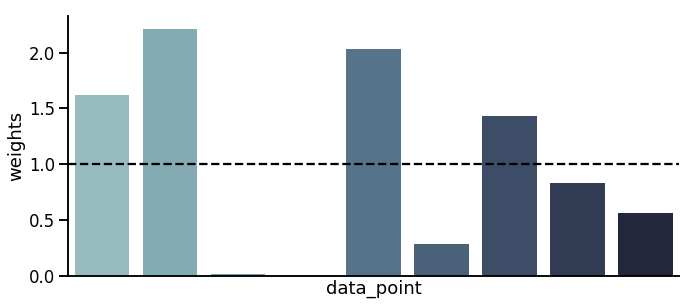

In [17]:
sns.set_context('talk')
g = plot_distance_weights(model, distance_fn)

In [18]:
print(distance_fn.w)

{0: {0: 1.623698334570911, 1: 2.2178029171387856, 2: 0.009717925486541391, 3: 0.006871611010598997, 4: 2.0326499488564727, 5: 0.28568015663160984, 6: 1.4304399002321044, 7: 0.8285076357699662, 8: 0.5646315703030105}}


In [19]:
g.savefig('results/extra/dist_weights.pdf')

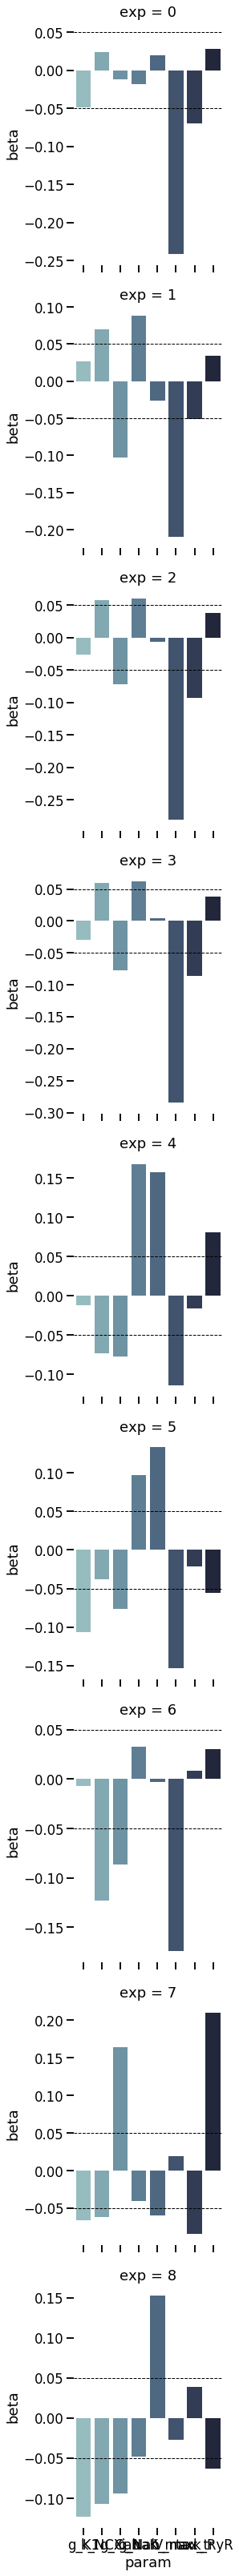

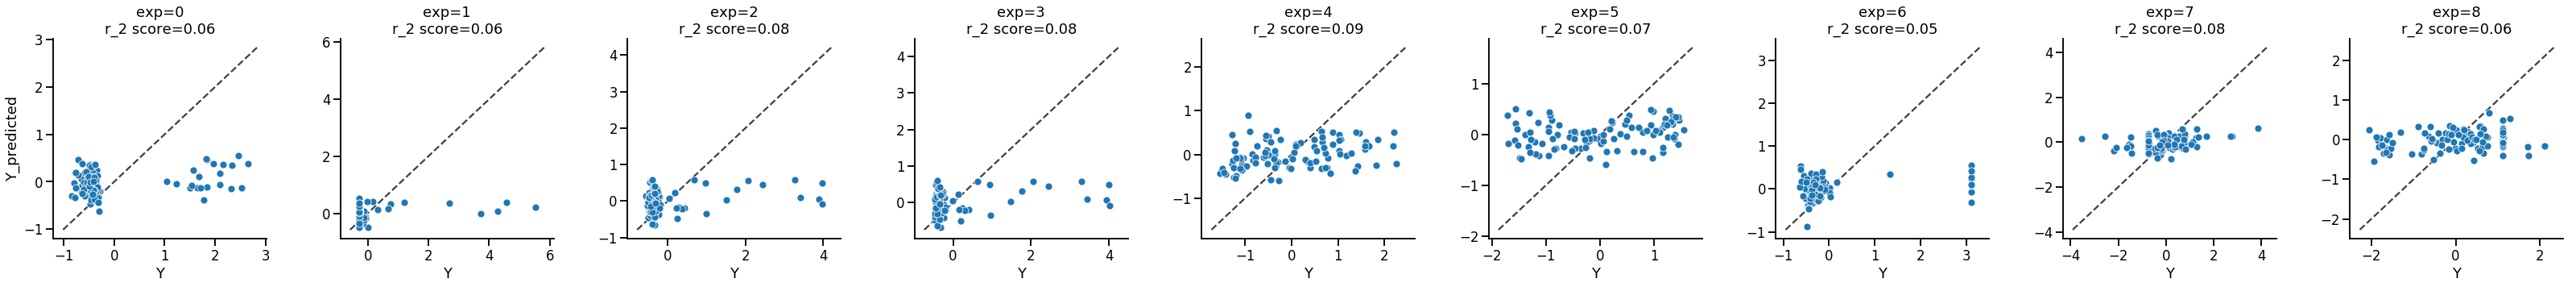

In [21]:
sns.set_context('talk')
grid1, grid2 = plot_parameter_sensitivity(
    model,
    parameters,
    distance_fn,
    sigma=0.1,
    n_samples=100,
    plot_cutoff=0.05)

In [22]:
grid1.savefig('results/extra/sensitivity.pdf')
grid2.savefig('results/extra/sensitivity_fit.pdf')

# Initialise database

In [16]:
db_path = ('sqlite:///' + 
           os.path.join(tempfile.gettempdir(), "hl-1_extra.db"))
print(db_path)

sqlite:////scratch/cph211/tmp/hl-1_extra.db


In [17]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [19]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 obs=obs,
                 exp_map=exp,
                 err_bars=errs,
                 err_th=0.01),
             population_size=AdaptivePopulationSize(
                 start_nr_particles=5000,
                 mean_cv=0.2,
                 max_population_size=5000,
                 min_population_size=500),
             summary_statistics=ion_channel_sum_stats_calculator,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(),
             sampler=MulticoreEvalParallelSampler(n_procs=12),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {0: 1.623698334570911, 1: 2.2178029171387856, 2: 0.006871611010598997, 3: 0.009717925486541391, 4: 2.0326499488564727, 5: 0.28568015663160984, 6: 1.4304399002321044, 7: 0.8285076357699662, 8: 0.5646315703030105}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=from_sample, quantile_multiplier=1


In [20]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2018-10-08 15:54:40.629328, end_time=None)>
INFO:Epsilon:initial epsilon is 252.35707171808468


In [21]:
history = abc.run(minimum_epsilon=0.01, max_nr_populations=10, min_acceptance_rate=0.001)

INFO:ABC:t:0 eps:252.35707171808468
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 15139
DEBUG:Epsilon:new eps, t=1, eps=156.95181541986412
INFO:ABC:t:1 eps:156.95181541986412
INFO:Adaptation:Change nr particles 5000 -> 4294
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 31485
DEBUG:Epsilon:new eps, t=2, eps=111.90707960969301
INFO:ABC:t:2 eps:111.90707960969301
INFO:Adaptation:Change nr particles 4294 -> 4040
DEBUG:ABC:now submitting population 2
DEBUG:ABC:population 2 done
DEBUG:ABC:
total nr simulations up to t =2 is 52116
DEBUG:Epsilon:new eps, t=3, eps=90.81795908187684
INFO:ABC:t:3 eps:90.81795908187684
INFO:Adaptation:Change nr particles 4040 -> 3448
DEBUG:ABC:now submitting population 3
DEBUG:ABC:population 3 done
DEBUG:ABC:
total nr simulations up to t =3 is 73717
DEBUG:Epsilon:new eps, t=4, eps=76.04107759262502
INFO:ABC:t:4 eps:76.04107759262502
I

In [ ]:
history = abc.run(minimum_epsilon=0.01, max_nr_populations=5, min_acceptance_rate=0.001)

INFO:ABC:t:10 eps:33.829841483800884
INFO:Adaptation:Change nr particles 2802 -> 2773
DEBUG:ABC:now submitting population 10
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Process Process-137:
Process Process-141:
Process Process-135:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-6a8c5558fdb0>", line 1, in <module>
    history = abc.run(minimum_epsilon=0.01, max_nr_populations=5, min_acceptance_rate=0.001)
  File "/scratch/cph211/pyabc/pyabc/smc.py", line 671, in run
    self.population_strategy.nr_particles, simulate_one)
  File "/scratch/cph211/pyabc/pyabc/sampler/multicore_evaluation_parallel.py", line 111, in sample_until_n_accepted
    val = get_if_worker_healthy(processes, queue)
  File "/scratch/cph211/pyabc/pyabc/sampler/multicorebase.py", line 53, in get_if_worker_healthy
    item = queue.get(True, 5)
  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/p

  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


KeyboardInterrupt: 

  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/scratch/cph211/pyabc/pyabc/sampler/multicore_evaluation_parallel.py", line 24, in work
    new_sim = simulate_one()
  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/scratch/cph211/pyabc/pyabc/sampler/multicore_evaluation_parallel.py", line 24, in work
    new_sim = simulate_one()
  File "/scratch/cph211/pyabc/pyabc/smc.py", line 663, in simulate_one
    par = self._generate_valid_proposal(t, m, p)
  File "/scratch/cph211/pyabc/pyabc/sampler/multicore_evaluation_parallel.py", line 24, in work
    new_sim = simulate_one()
  File "/scratch/cph211/pyabc/pyabc/smc.py", line 4

In [ ]:
history = abc.run(minimum_epsilon=0.01, max_nr_populations=5, min_acceptance_rate=0.001)

# Results analysis

In [6]:
#db_path = 'sqlite:///results/extra/hl-1_extra.db'
db_path = 'sqlite:////scratch/cph211/tmp/hl-1_extra.db'
history = History(db_path)
history.all_runs()

[<ABCSMC(id=1, start_time=2018-10-08 15:54:40.629328, end_time=2018-10-09 00:01:46.373436)>]

In [7]:
history.id = 1

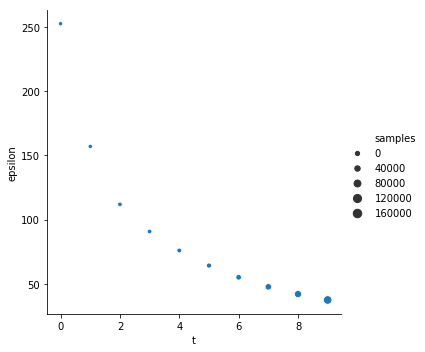

In [8]:
evolution = history.get_all_populations()
grid = sns.relplot(x='t', y='epsilon', size='samples', data=evolution[evolution.t>=0])
grid.savefig('results/extra/eps_evolution.pdf')

In [26]:
df, w = history.get_distribution(m=0)

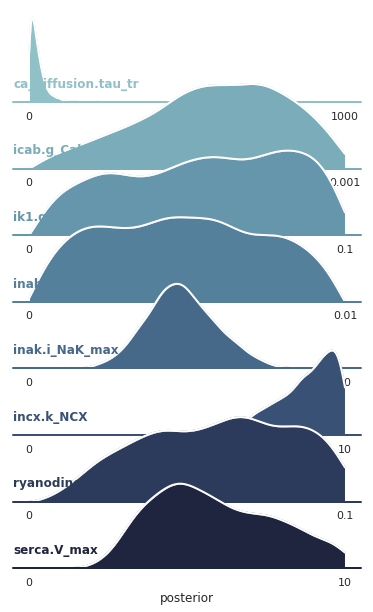

In [27]:
from ionchannelABC import plot_parameters_kde
g = plot_parameters_kde(df, w, limits, aspect=5, height=1.1)

# Samples for quantitative analysis

In [21]:
# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')

In [ ]:
# Generate sim results samples
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    output = model.sample(pars=th)
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [45]:
samples.head(10)

,distribution,exp,sample,x,y
0,post,0.0,0,v_rest,-70.054908
1,post,0.0,0,Ca_i,0.241688
2,post,0.0,0,Na_i,16762.635779
3,post,0.0,0,K_i,120447.444580
4,post,1.0,0,apa,97.890969
5,post,1.0,0,apd90,47.553762
6,post,1.0,0,t_ca_rise,55.323615
7,post,1.0,0,t_ca50,148.171404
8,post,1.0,0,t_ca90,395.661534
9,post,0.0,1,v_rest,-74.410922


# Evaluate results

In [46]:
import scipy.stats as st
def evaluate_samples(samples):
    for measurement in samples['x'].unique():
        filtered = samples[samples.x==measurement]['y'].tolist()
        rv = st.rv_discrete(values=(filtered, [1/len(filtered),]*len(filtered)))
        print("{}, median: {}".format(measurement, rv.median()))
        print("{}, 95% CI: {}".format(measurement, rv.interval(0.95)))

In [48]:
evaluate_samples(samples)

v_rest, median: -70.83298464171448
v_rest, 95% CI: (-76.82066593111263, -29.9262016276886)
Ca_i, median: 0.18987221502052426
Ca_i, 95% CI: (0.10808887433568047, 79.52871950113637)
Na_i, median: 15487.809306595811
Na_i, 95% CI: (12223.403454647567, 70317.67039848573)
K_i, median: 121807.20571955516
K_i, 95% CI: (66884.30381139874, 126810.49619326017)
apa, median: 79.21842792780917
apa, 95% CI: (44.41734338408779, 122.64106470592316)
apd90, median: 38.634519885032205
apd90, 95% CI: (3.911797146894969, 179.3982193817792)
t_ca_rise, median: 57.6539453107398
t_ca_rise, 95% CI: (5.1347845583513845, 485.8535324546392)
t_ca50, median: 161.63296865747543
t_ca50, 95% CI: (0.0, 264.90229196226574)
t_ca90, median: 413.313981016312
t_ca90, 95% CI: (0.0, 603.1098158859822)


In [49]:
samp_pivot = samples.pivot(index='sample', columns='x', values='y')

In [50]:
from sklearn.cluster import AffinityPropagation

In [51]:
af = AffinityPropagation()

In [52]:
af.fit(samp_pivot.values)

AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
          damping=0.5, max_iter=200, preference=None, verbose=False)

In [53]:
centers = pd.DataFrame(af.cluster_centers_, columns=samp_pivot.columns)

In [55]:
af.cluster_centers_indices_

array([  32,   45,  334,  576,  618,  644,  769,  796,  938,  964, 1000,
       1056, 1062, 1122, 1130, 1182, 1238, 1244, 1258, 1263, 1276, 1289,
       1331, 1394, 1475, 1509, 1589, 1604, 1642, 1688, 1703, 1736, 1899,
       1905, 1965, 1971, 2006, 2068, 2082, 2102, 2134, 2137, 2141, 2220,
       2328, 2412, 2451, 2642, 2700, 2746, 2754, 2770, 2842, 2853, 2864,
       2925, 2963, 3027, 3028, 3029, 3083, 3093, 3242, 3264, 3377, 3385,
       3433, 3534, 3551, 3575, 3606, 3691, 3840, 3865, 3870, 4001, 4016,
       4043, 4115, 4121, 4248, 4282, 4351, 4360, 4406, 4410, 4431, 4595,
       4632, 4683, 4695, 4701, 4784])

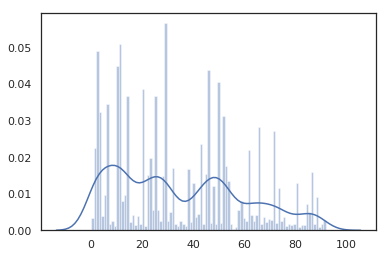

In [56]:
sns.distplot(af.labels_, bins=len(af.cluster_centers_))

## Plot sample of voltage traces

In [9]:
from ionchannelABC import (Experiment, ExperimentStimProtocol)

In [10]:
# Create new experiment to generate traces
n_pulses = 1000
stim_times = [100000] + [2, 998]*n_pulses + [2, 998]
stim_levels = [0] + [40, 0]*n_pulses + [40, 0]
time = np.linspace(0, 1000, 5000) # interpolation time points
def trace_measurements(data_list):
    import numpy as np
    data = data_list[0]
    if len(data_list) > 1:
        for log in data_list[1:]:
            data = data.extend(log)
    simtime = data['environment.time']
    simtime_min = min(simtime)
    simtime = [t - simtime_min for t in simtime]
    data_output = dict()
    data['environment.time'] = simtime
    for var in data:
        data_output[var] = np.interp(time, simtime, data[var])
    return data_output
def unwrap(data, ind_var):
    return data[0], True
trace_prot = ExperimentStimProtocol(stim_times, stim_levels, 
                                    measure_index=range(len(stim_times)-2, len(stim_times)),
                                    measure_fn=trace_measurements,
                                    post_fn=unwrap)
dias_conditions = dict(T=305, Ca_o=1800, Na_o=1.4e5, K_o=4e3)
trace_exper = Experiment(trace_prot, None, dias_conditions)

In [11]:
model.add_experiments([trace_exper])

In [22]:
# Generate traces
traces = pd.DataFrame({})
for i, th in enumerate(th_samples):
    output = model.sample(pars=th,exp_num=2)
    output['sample'] = i
    traces = traces.append(output, ignore_index=True)

In [75]:
import pickle
with open('traces.pkl','wb') as f:
    pickle.dump(traces, f)

In [12]:
import pickle
with open('traces.pkl','rb') as f:
    traces = pickle.load(f)

In [19]:
traces.x.unique()

array(['membrane.V', 'ical.d', 'ical.f', 'ical.fCa', 'ina.m', 'ina.h',
       'ina.j', 'ito.xto', 'ito.yto', 'ikr.C_K1', 'ikr.C_K2', 'ikr.O_K',
       'ikr.I_K', 'ikur.a_ur', 'ikur.i_ur', 'icat.b', 'icat.g', 'iha.y',
       'ryanodine_receptors.P_open', 'ca_conc_sr.Ca_SRuptake',
       'ca_conc_sr.Ca_SRrelease', 'ca_conc.Ca_i', 'na_conc.Na_i',
       'k_conc.K_i', 'environment.time', 'ina.E_Na', 'ina.G_Na',
       'ina.i_Na', 'ina.m_ss', 'ina.tau_m', 'ina.h_ss', 'ina.tau_h_high',
       'ina.tau_h_low', 'ina.tau_h', 'ina.j_ss', 'ina.tau_j_high',
       'ina.tau_j_low', 'ina.tau_j', 'ikr.G_Kr', 'ikr.E_Kr', 'ikr.i_Kr',
       'ikr.alpha_a0', 'ikr.alpha_a1', 'ikr.alpha_i', 'ikr.beta_a0',
       'ikr.beta_a1', 'ikr.beta_i', 'ikr.C_K0', 'ikur.G_Kur',
       'ikur.i_Kur', 'ikur.a_ur_ss', 'ikur.tau_a_ur', 'ikur.i_ur_ss',
       'ikur.tau_i_ur', 'ito.G_to', 'ito.i_to', 'ito.xto_ss',
       'ito.tau_xto', 'ito.yto_ss', 'ito.tau_yto', 'iha.G_ha',
       'iha.i_haNa', 'iha.i_haK', 'iha.i_ha', 'ih

In [134]:
val = pd.DataFrame(traces[traces.x=='ina.i_Na'].y.tolist())

In [135]:
plotdata = val[9:10].melt()

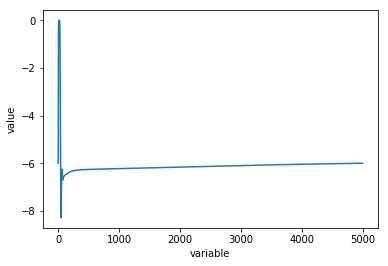

In [136]:
sns.lineplot(x='variable',y='value',data=plotdata,estimator=None)

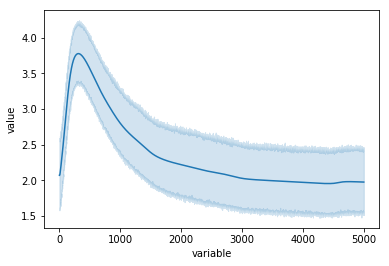

In [74]:
sns.lineplot(x='variable',y='value',data=val.melt())